In [70]:
# Dependencies
import copy
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn.functional as F
from utils import util_net

from basicsr.data import build_dataloader, build_dataset
from basicsr.data.degradations import add_jpg_compression
from basicsr.metrics import calculate_psnr, calculate_ssim
from basicsr.utils import FileClient, imfrombytes, img2tensor, tensor2img, scandir

import datapipe

# INN Evaluation

The goal of this notebook is to investigate whether the INN models used as part of INDIGO are being trained effectively

## Quantitative Analysis

In [66]:
from inn.network_cinn import RWNN

num_gpus = torch.cuda.device_count()
rank = int(os.environ['LOCAL_RANK']) if num_gpus > 1 else 0
device = torch.device(f'cuda:{rank}')

def load_model(model, ckpt_path=None,strict=True):
    # if self.rank == 0:
        # print(f'Loading from {ckpt_path}...', flush=True)
    ckpt = torch.load(ckpt_path, map_location=f"cuda:{rank}")
    if 'state_dict' in ckpt:
        ckpt = ckpt['state_dict']
    elif 'params' in ckpt:
        ckpt = ckpt['params']
    util_net.reload_model(model, ckpt,strict=strict)
    if rank == 0:
        print('Loaded Done', flush=True)

def freeze_model(net):
    for params in net.parameters():
        params.requires_grad = False
        
INN_dir = "weights/INN/initial/INN_JPEG_QF10.pth"
basic_block_type = "rb_cres_kdsr"
netG = RWNN(offset=0.5, LiftNet_iter=2, basic_block_type=basic_block_type, net_kdsr=None, kdsr=1).cuda()

model_inn = netG
load_model(netG,INN_dir,strict=True)
initial_inn_state = copy.deepcopy(model_inn.state_dict())
model_inn.eval()
freeze_model(model_inn)

dummy_emb = torch.ones(128).to(device)

Loaded Done


In [67]:
def calculate_psnr_alt(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * (np.log10(abs(max_value) / (np.sqrt(mse)))).item()

def calculate_mse(img1, img2):
    return (np.mean((img1 - img2) ** 2)).item()

def calculate_rmse(img1, img2):
    return (np.sqrt(calculate_mse(img1, img2))).item()

In [68]:
def evaluate_models(model_path):
    qf = range(0,100,10)

    dataset_opt = {
        'name': 'FFHQJPEGTest',
        'type': 'FFHQJPEGDataset',
        'phase': 'test',
        'gt_size': 512,
        'scale': 4,
        'encsize': True,
        'qf': qf,
        'dataroot_gt': 'datasets/ffhq/test',
        'io_backend':
            {'type': 'disk'} 
    }

    psnr = []
    ssim = []
    for f in qf:
        dataset_opt['qf'] = f
    
        # Dataset
        test_set = build_dataset(dataset_opt)
        test_loader = build_dataloader(
                    test_set,
                    dataset_opt,
                    num_gpu=1,
                    dist=False,
                    sampler=None,
                    seed=0)
    
        # Model
        INN_dir = os.path.join(model_path,f'INN_JPEG_QF{f}.pth')
        load_model(netG,INN_dir,strict=True)
        initial_inn_state = copy.deepcopy(model_inn.state_dict())
        model_inn.eval()
        freeze_model(model_inn)
        
        psnr.append(0)
        ssim.append(0)
        for idx, val_data in enumerate(test_loader):
            img_hq = val_data['gt'] # 512x512
            img_lq = val_data['lq'] # 128x128
            encsize = val_data['encsize'].item()
    
            img_hq = img_hq.to(device)
            c, _ = model_inn.dae_f(x=img_hq, cond=dummy_emb, layer=2)
            
            c = c.detach().cpu()
            img_lq, c = tensor2img([img_lq, c], rgb2bgr=False)
            psnr[-1] += calculate_psnr_alt(img_lq, c, img_lq.max())
            ssim[-1] += calculate_ssim(img_lq, c, 0)
        psnr[-1] = psnr[-1] / len(test_set)
        ssim[-1] = ssim[-1] / len(test_set)
        print(f'JPEG qf{f}: PSNR {psnr[-1]} SSIM {ssim[-1]}')

    return psnr, ssim

In [69]:
results = dict()

print('Approach 0: 1600 training images, mse loss')
psnr, ssim = evaluate_models('weights/INN/large')
tmp = dict()
tmp['psnr'] = psnr
tmp['ssim'] = ssim
results['MSE'] = tmp

print('Approach 0: 10000 training images, mse+perceptual loss')
psnr, ssim = evaluate_models('weights/INN/large_percep')
tmp = dict()
tmp['psnr'] = psnr
tmp['ssim'] = ssim
results['multi-obj'] = tmp

Approach 0: 1600 training images, mse loss
Loaded Done
JPEG qf0: PSNR 28.672316131675267 SSIM 0.5717376644524554
Loaded Done
JPEG qf10: PSNR 30.336269298376234 SSIM 0.7948951312079005
Loaded Done
JPEG qf20: PSNR 31.21438034343768 SSIM 0.8390623064973152
Loaded Done
JPEG qf30: PSNR 31.71082313327323 SSIM 0.8591994888417411
Loaded Done
JPEG qf40: PSNR 31.99959638985487 SSIM 0.8686535718276194
Loaded Done
JPEG qf50: PSNR 32.185762083571376 SSIM 0.8750814448139935
Loaded Done
JPEG qf60: PSNR 32.31685473580284 SSIM 0.8802799648386173
Loaded Done
JPEG qf70: PSNR 32.501477028899565 SSIM 0.8867325855008911
Loaded Done
JPEG qf80: PSNR 32.744229428923205 SSIM 0.8952145464626731
Loaded Done
JPEG qf90: PSNR 33.23493195083789 SSIM 0.9087521826959026
Approach 0: 10000 training images, mse+perceptual loss
Loaded Done
JPEG qf0: PSNR 28.536122403081748 SSIM 0.5301249769068452
Loaded Done
JPEG qf10: PSNR 29.551285019157522 SSIM 0.7412318033821288
Loaded Done
JPEG qf20: PSNR 30.533970127817756 SSIM 0.804

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


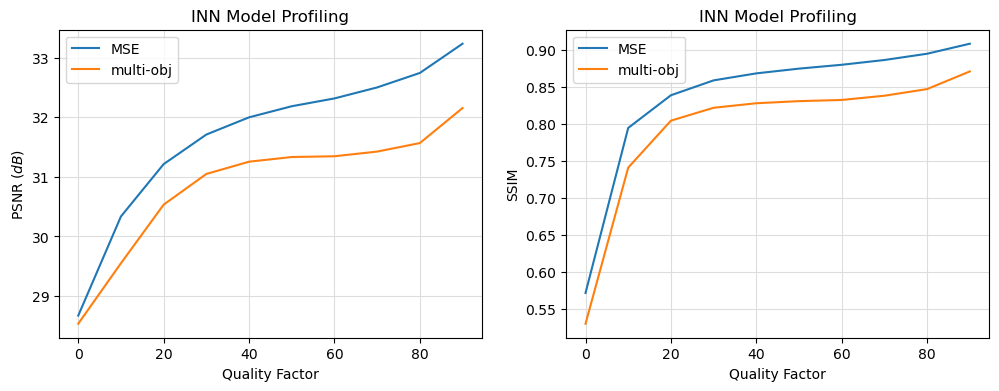

In [81]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=(12, 4))
qf = range(0,100,10)

# plot 1
for key in results:
    axs[0].plot(qf,results[key]['psnr'], label=key)
axs[0].set_title('INN Model Profiling, PSNR')
axs[0].set_xlabel('Quality Factor')
axs[0].set_ylabel('PSNR ($dB$)')
axs[0].grid(which='major', color='#DDDDDD', linewidth=0.8)
axs[0].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[0].legend()

# plot 2
for key in results:
    axs[1].plot(qf,results[key]['ssim'], label=key)
axs[1].set_title('INN Model Profiling, SSIM')
axs[1].set_xlabel('Quality Factor')
axs[1].set_ylabel('SSIM')
axs[1].grid(which='major', color='#DDDDDD', linewidth=0.8)
axs[1].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
axs[1].legend()


fig.show() 

fig.savefig('figures/inn_profiling.eps')

In [71]:
print(json.dumps(results, indent=4))

with open('results/inn_profiling.json', 'w') as f:
    json.dump(results, f)

{
    "MSE": {
        "psnr": [
            28.672316131675267,
            30.336269298376234,
            31.21438034343768,
            31.71082313327323,
            31.99959638985487,
            32.185762083571376,
            32.31685473580284,
            32.501477028899565,
            32.744229428923205,
            33.23493195083789
        ],
        "ssim": [
            0.5717376644524554,
            0.7948951312079005,
            0.8390623064973152,
            0.8591994888417411,
            0.8686535718276194,
            0.8750814448139935,
            0.8802799648386173,
            0.8867325855008911,
            0.8952145464626731,
            0.9087521826959026
        ]
    },
    "multi-obj": {
        "psnr": [
            28.536122403081748,
            29.551285019157522,
            30.533970127817756,
            31.04937446174787,
            31.255312157100438,
            31.3335412133181,
            31.346236278351157,
            31.424906841543486

From the results above, it seems that the INN struggles to learn the compression process the heavier the compression level being applied. This can be attributed to the introduction of square artefacts in low quality factors. The frequency separation property of wavelet transforms impedes the INN from learning a forward coarse transform that adds high-frequency components. Another interpretation is that because we are using ResNets for he P U and merge networks, high quality factor compression is easier to learn because it is very close to an identity transformation. In comparison, low quality factor compression chnages the image much more, hence it is able to 

Next step: add ssim and maybe LPIPS. MSE is used as loss function, meaning models optimise for MSE and PSNR metrics. However, these may not reflect perceptual similarity as well as SSIM and LPIPS.

## Qualitative Analysis

In [38]:
# get the coarse component of the same image for each model
def get_coarse_examples(model_path):
    imgs_coarse = []
    imgs_lq = []
    qf = range(0,100,10)

    dataset_opt = {
        'name': 'FFHQJPEGTest',
        'type': 'FFHQJPEGDataset',
        'phase': 'test',
        'gt_size': 512,
        'scale': 4,
        'encsize': True,
        'qf': qf,
        'dataroot_gt': 'datasets/ffhq/test',
        'io_backend':
            {'type': 'disk'} 
    }


    for f in qf:
        dataset_opt['qf'] = f
    
        # Dataset
        test_set = build_dataset(dataset_opt)
        val_data = test_set[33]

        # Model
        INN_dir = os.path.join(model_path,f'INN_JPEG_QF{f}.pth')
        load_model(netG,INN_dir,strict=True)
        initial_inn_state = copy.deepcopy(model_inn.state_dict())
        model_inn.eval()
        freeze_model(model_inn)

        img_hq = val_data['gt'] # 512x512
        img_lq = val_data['lq'] # 128x128
    
        img_hq = img_hq.to(device)
        c, _ = model_inn.dae_f(x=img_hq[None,:,:,:], cond=dummy_emb, layer=2)
        img_lq, c = tensor2img([img_lq,c], rgb2bgr=False)

        imgs_lq.append(img_lq)
        imgs_coarse.append(c)
        
    return imgs_lq, imgs_coarse

In [48]:
imgs = []
imgs_lq, imgs_coarse = get_coarse_examples('weights/INN/large')
imgs.append(imgs_lq)
imgs.append(imgs_coarse)
imgs.append(get_coarse_examples('weights/INN/large_percep')[1])

Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done


In [49]:
print(len(imgs))
print(len(imgs[0]))

3
10


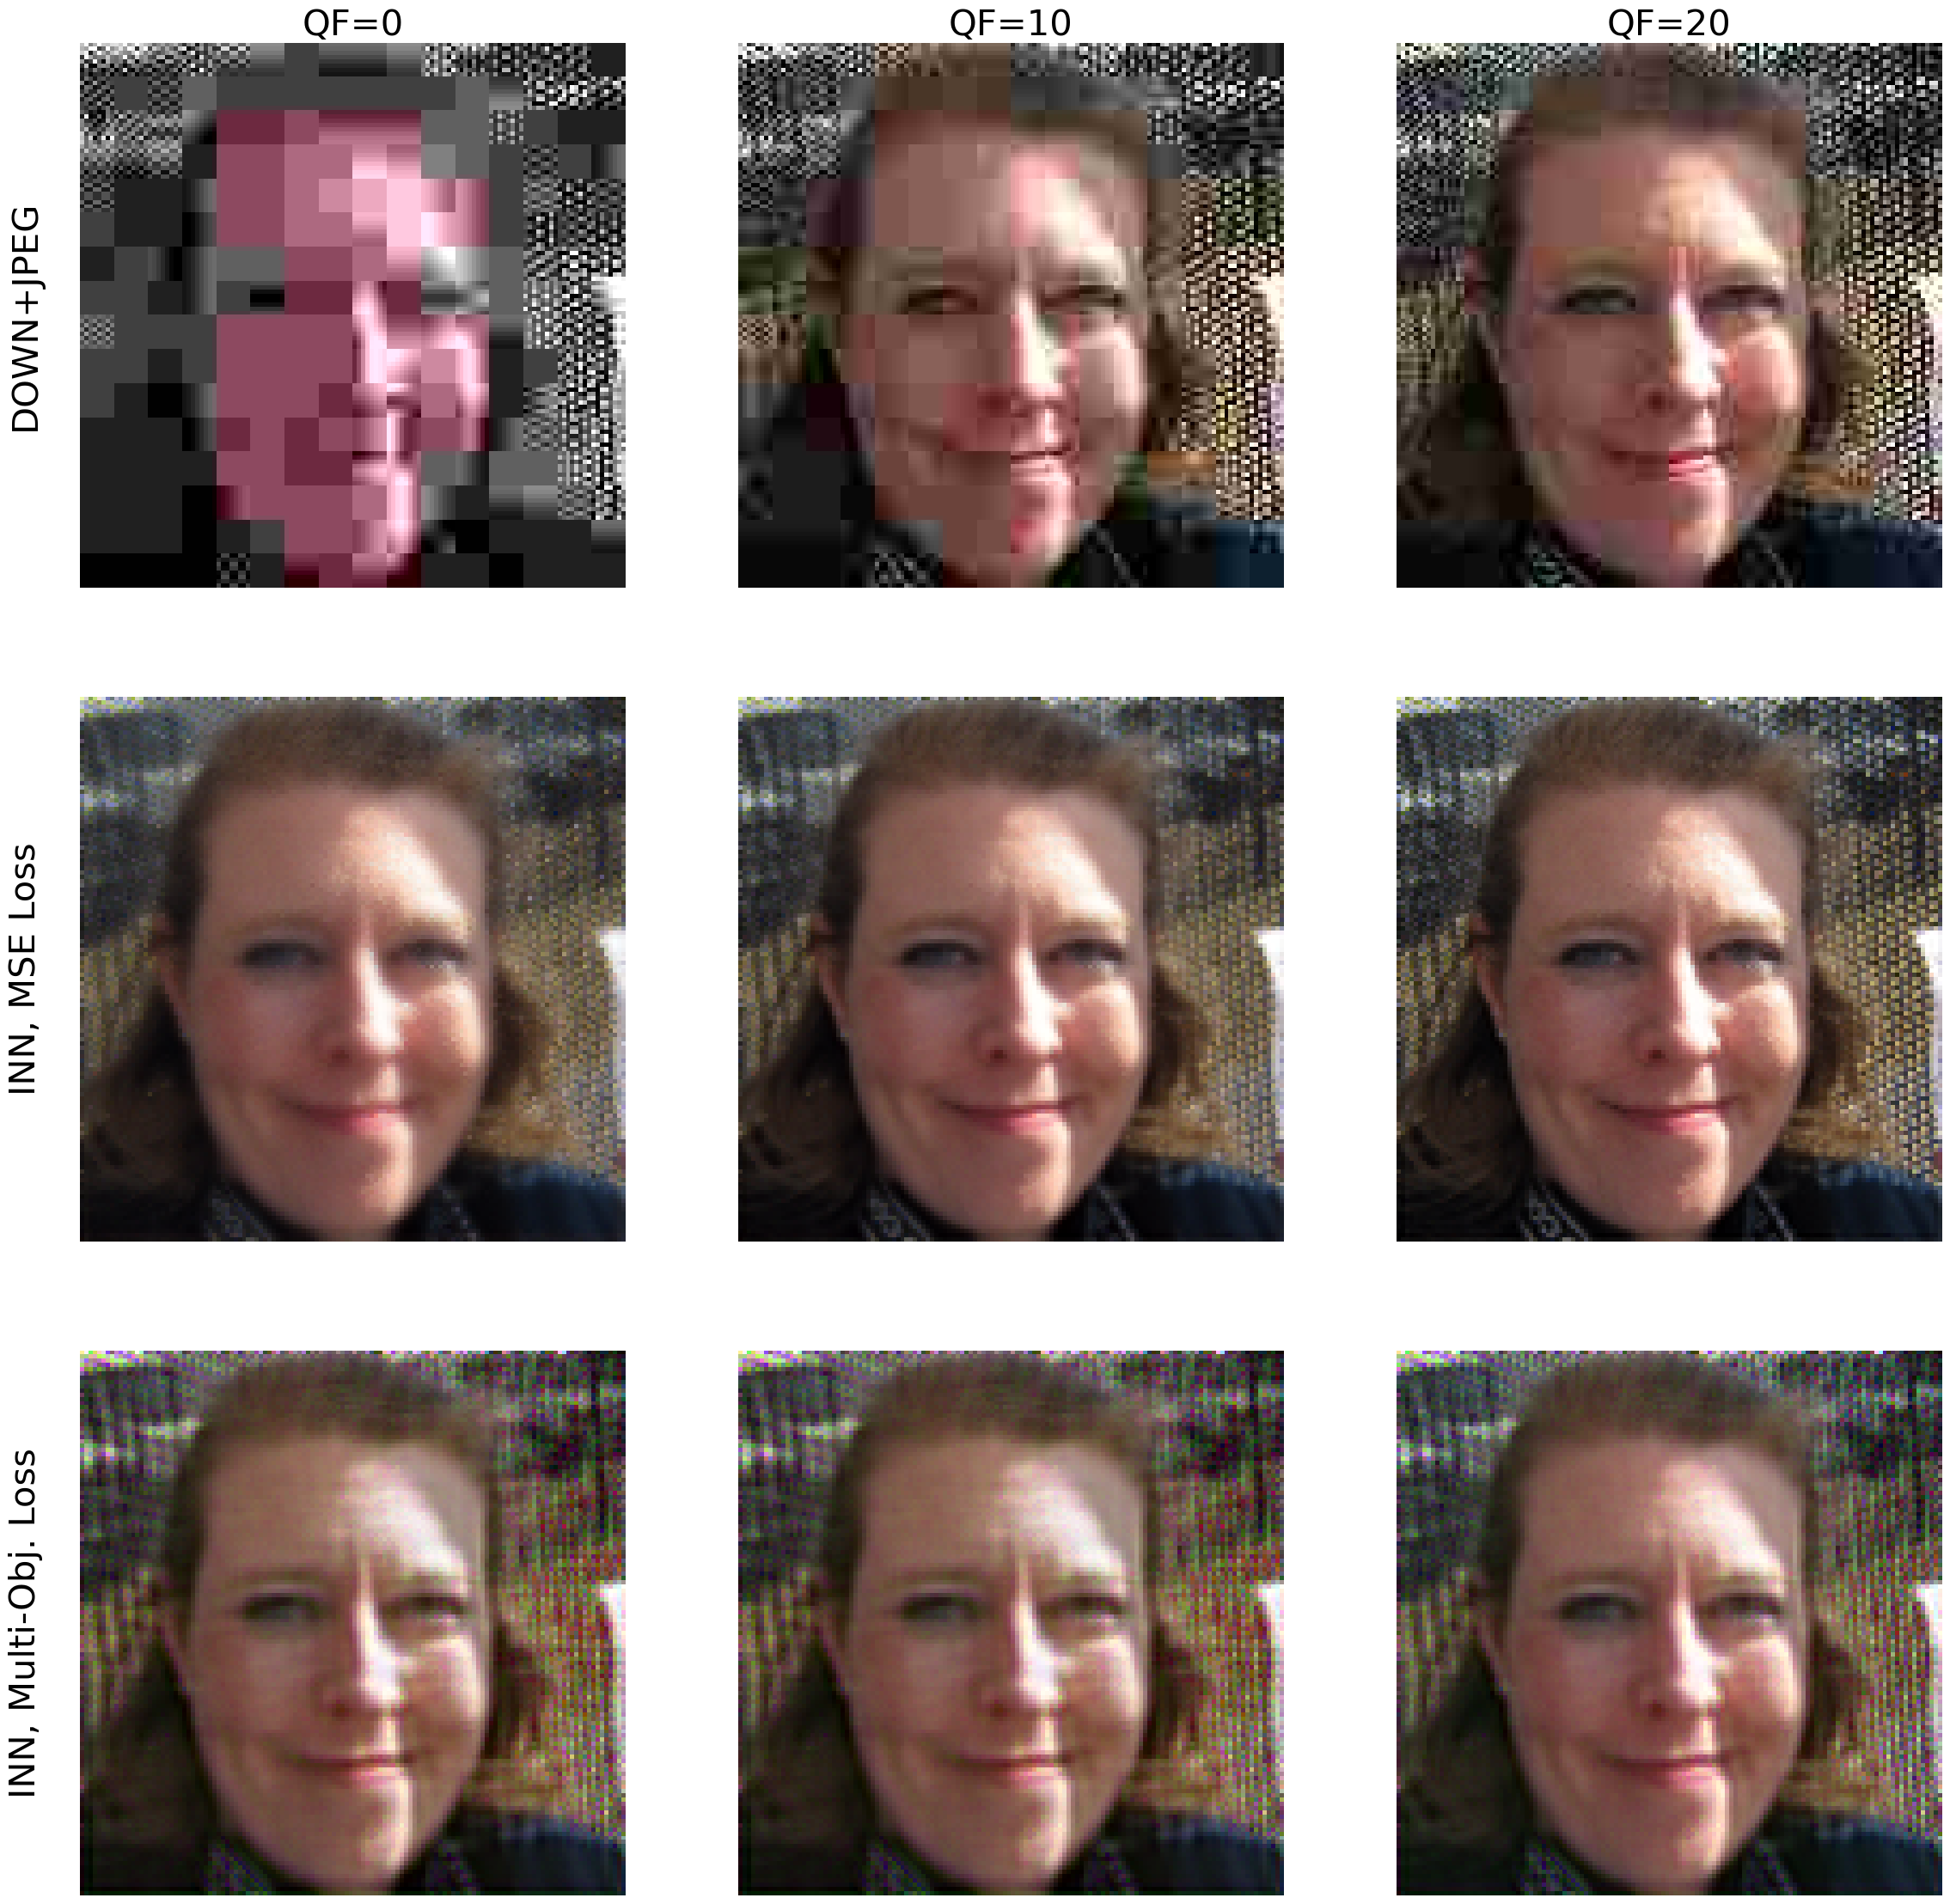

In [62]:
fig, axs = plt.subplots(3,3, figsize=(28, 28))
qf = range(0,100,10)
labels = [f'qf{f}' for f in qf]
hlabels = [f'QF={f}' for f in qf]
names = ['DOWN+JPEG','INN, MSE Loss','INN, Multi-Obj. Loss']

for j in range(3):
    axs[0,j].set_title(hlabels[j], fontsize=30)

for i in range(3):
    axs[i,0].text(-0.1, 0.5, names[i], va='center', ha='center',
        rotation='vertical', fontsize=30, transform=axs[i,0].transAxes)
    for j in range(3):
        axs[i,j].imshow(imgs[i][j])
        axs[i,j].axis('off')

fig.show()

In [63]:
fig.savefig('figures/qualitative_comparing_loss.png')

Loaded Done
layer 0:
	component 0 has shape torch.Size([1, 3, 128, 128])
	component 1 has shape torch.Size([1, 3, 128, 128])
	component 2 has shape torch.Size([1, 3, 128, 128])
layer 1:
	component 0 has shape torch.Size([1, 3, 256, 256])
	component 1 has shape torch.Size([1, 3, 256, 256])
	component 2 has shape torch.Size([1, 3, 256, 256])


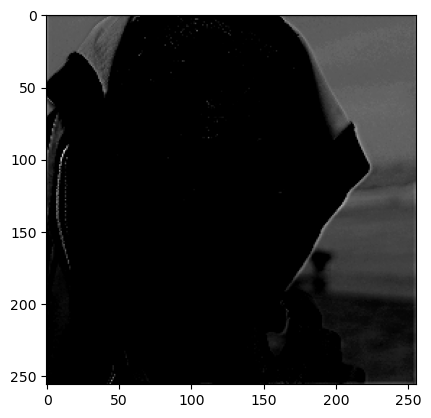

In [8]:
dataset_opt = {
    'name': 'FFHQJPEGTest',
    'type': 'FFHQJPEGDataset',
    'phase': 'test',
    'gt_size': 512,
    'scale': 4,
    'encsize': True,
    'qf': qf,
    'dataroot_gt': 'datasets/ffhq/test',
    'io_backend':
        {'type': 'disk'} 
}

model_path = 'weights/INN/initial'
dataset_opt['qf'] = 0
f = 0
    
# Dataset
test_set = build_dataset(dataset_opt)
val_data = test_set[20]

# Model
INN_dir = os.path.join(model_path,f'INN_JPEG_QF{f}.pth')
load_model(netG,INN_dir,strict=True)
initial_inn_state = copy.deepcopy(model_inn.state_dict())
model_inn.eval()
freeze_model(model_inn)

img_hq = val_data['gt'] # 512x512
img_lq = val_data['lq'] # 128x128
    
img_hq = img_hq.to(device)
_, d = model_inn.dae_f(x=img_hq[None,:,:,:], cond=dummy_emb, layer=2)

detail = tensor2img(d[1][0], rgb2bgr=False)[0]
plt.imshow(detail[:,:,2], cmap='gray')

for i,layer in enumerate(d):
    print(f'layer {i}:')
    for j,component in enumerate(layer):
        print(f'\tcomponent {j} has shape {component.shape}')



The images produced by the networks trained with perceptual loss seem to better capture the blur and colour changes caused by JPEG compression. We can take a horizontal slice of the image to see how the learned transforms differ.

In [9]:
# Plot a 1D cross-section of the image to visualize the effect of the transform
# Made to be compatible with HWC numpy array
def get_slice(img, channel, idx, vert=False):
    img = img.squeeze()
    if vert:
        slice = img[:,idx,channel]
    else:
        slice = img[idx,:,channel]

    return slice

In [10]:
slices = []
for i in range(len(imgs)):
    slices.append([get_slice(img, 0, 63) for img in imgs[i]])

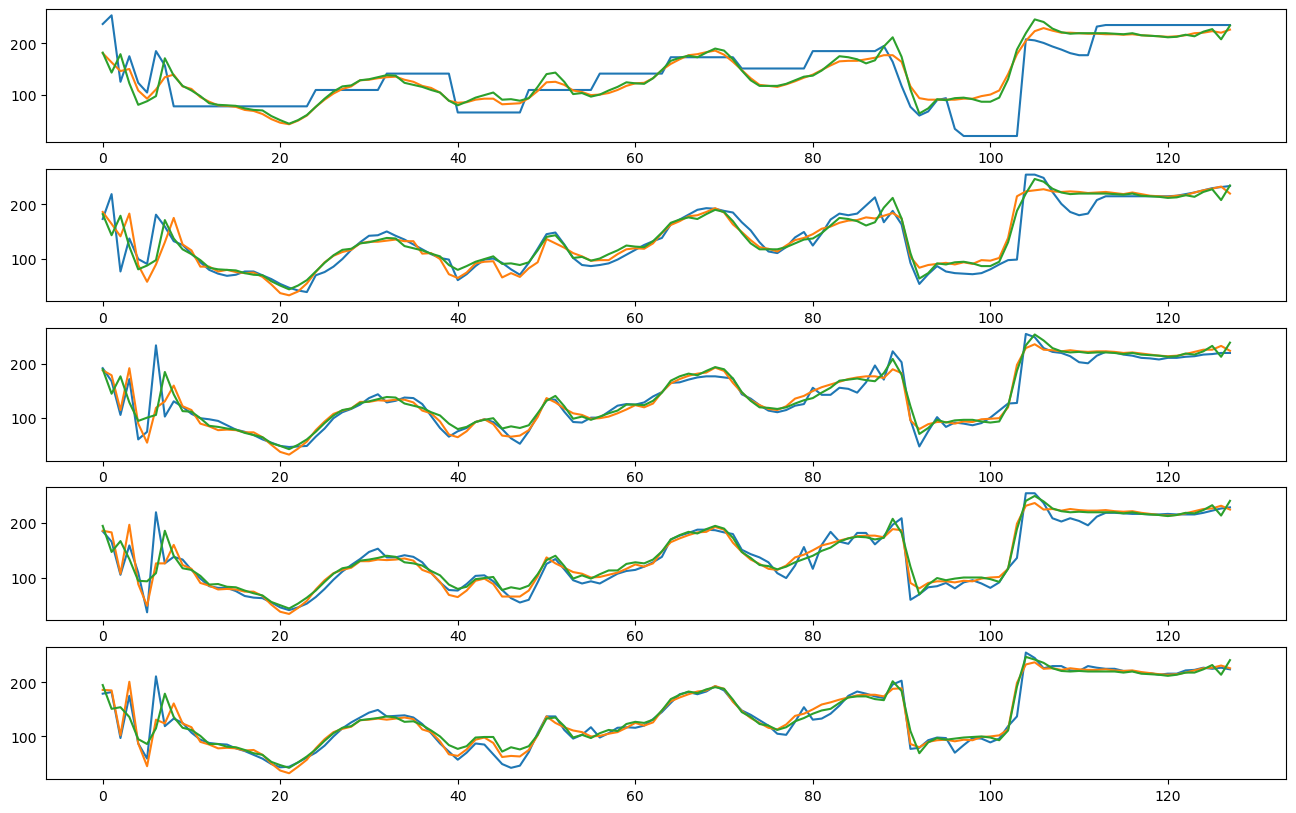

In [11]:
fig, axs = plt.subplots(5,1, figsize=(16, 10))
labels = [f'qf{f}' for f in qf]
names = ['JPEG','scheme 1','scheme 2']

for j in range(5):
    for i in range(3):
        axs[j].plot(slices[i][j])

fig.show()

## Explaining the lack of Artefacts

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

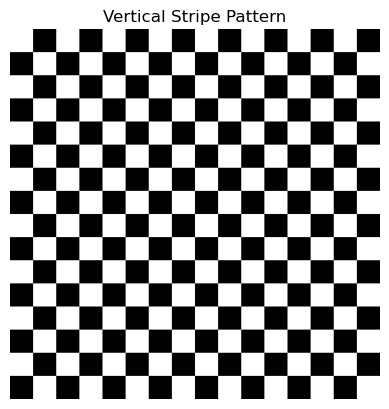

In [12]:
def generate_stripe_image(height, width, stripe_width=4, orientation='vertical'):
    """
    Generate a black-and-white stripe pattern image.
    
    Args:
        height (int): Image height.
        width (int): Image width.
        stripe_width (int): Width of each stripe in pixels.
        orientation (str): 'vertical', 'horizontal', or 'checkerboard'.
        
    Returns:
        np.ndarray: Stripe pattern image (H, W) with values 0 or 255.
    """
    if orientation == 'vertical':
        pattern = np.tile([0, 255], (width // (2 * stripe_width)) + 1)
        stripe_row = np.repeat(pattern, stripe_width)[:width]
        image = np.tile(stripe_row, (height, 1))
    
    elif orientation == 'horizontal':
        pattern = np.tile([0, 255], (height // (2 * stripe_width)) + 1)
        stripe_col = np.repeat(pattern, stripe_width)[:height]
        image = np.tile(stripe_col[:, np.newaxis], (1, width))
    
    elif orientation == 'checkerboard':
        row_pattern = np.tile([0, 255], (width // (2 * stripe_width)) + 1)
        row = np.repeat(row_pattern, stripe_width)[:width]
        img = np.tile(row, (height, 1))
        for i in range(0, height, stripe_width * 2):
            img[i:i + stripe_width] = 255 - img[i:i + stripe_width]
        image = img
    else:
        raise ValueError("Orientation must be 'vertical', 'horizontal', or 'checkerboard'.")

    return image.astype(np.uint8)

# Example usage
stripe_img = generate_stripe_image(512, 512, stripe_width=32, orientation='checkerboard')
stripe_img = stripe_img[:,:,None]

# Display
plt.imshow(stripe_img, cmap='gray', vmin=0, vmax=255)
plt.title("Vertical Stripe Pattern")
plt.axis('off')

Loaded Done
Loaded Done
Loaded Done
Loaded Done
Loaded Done


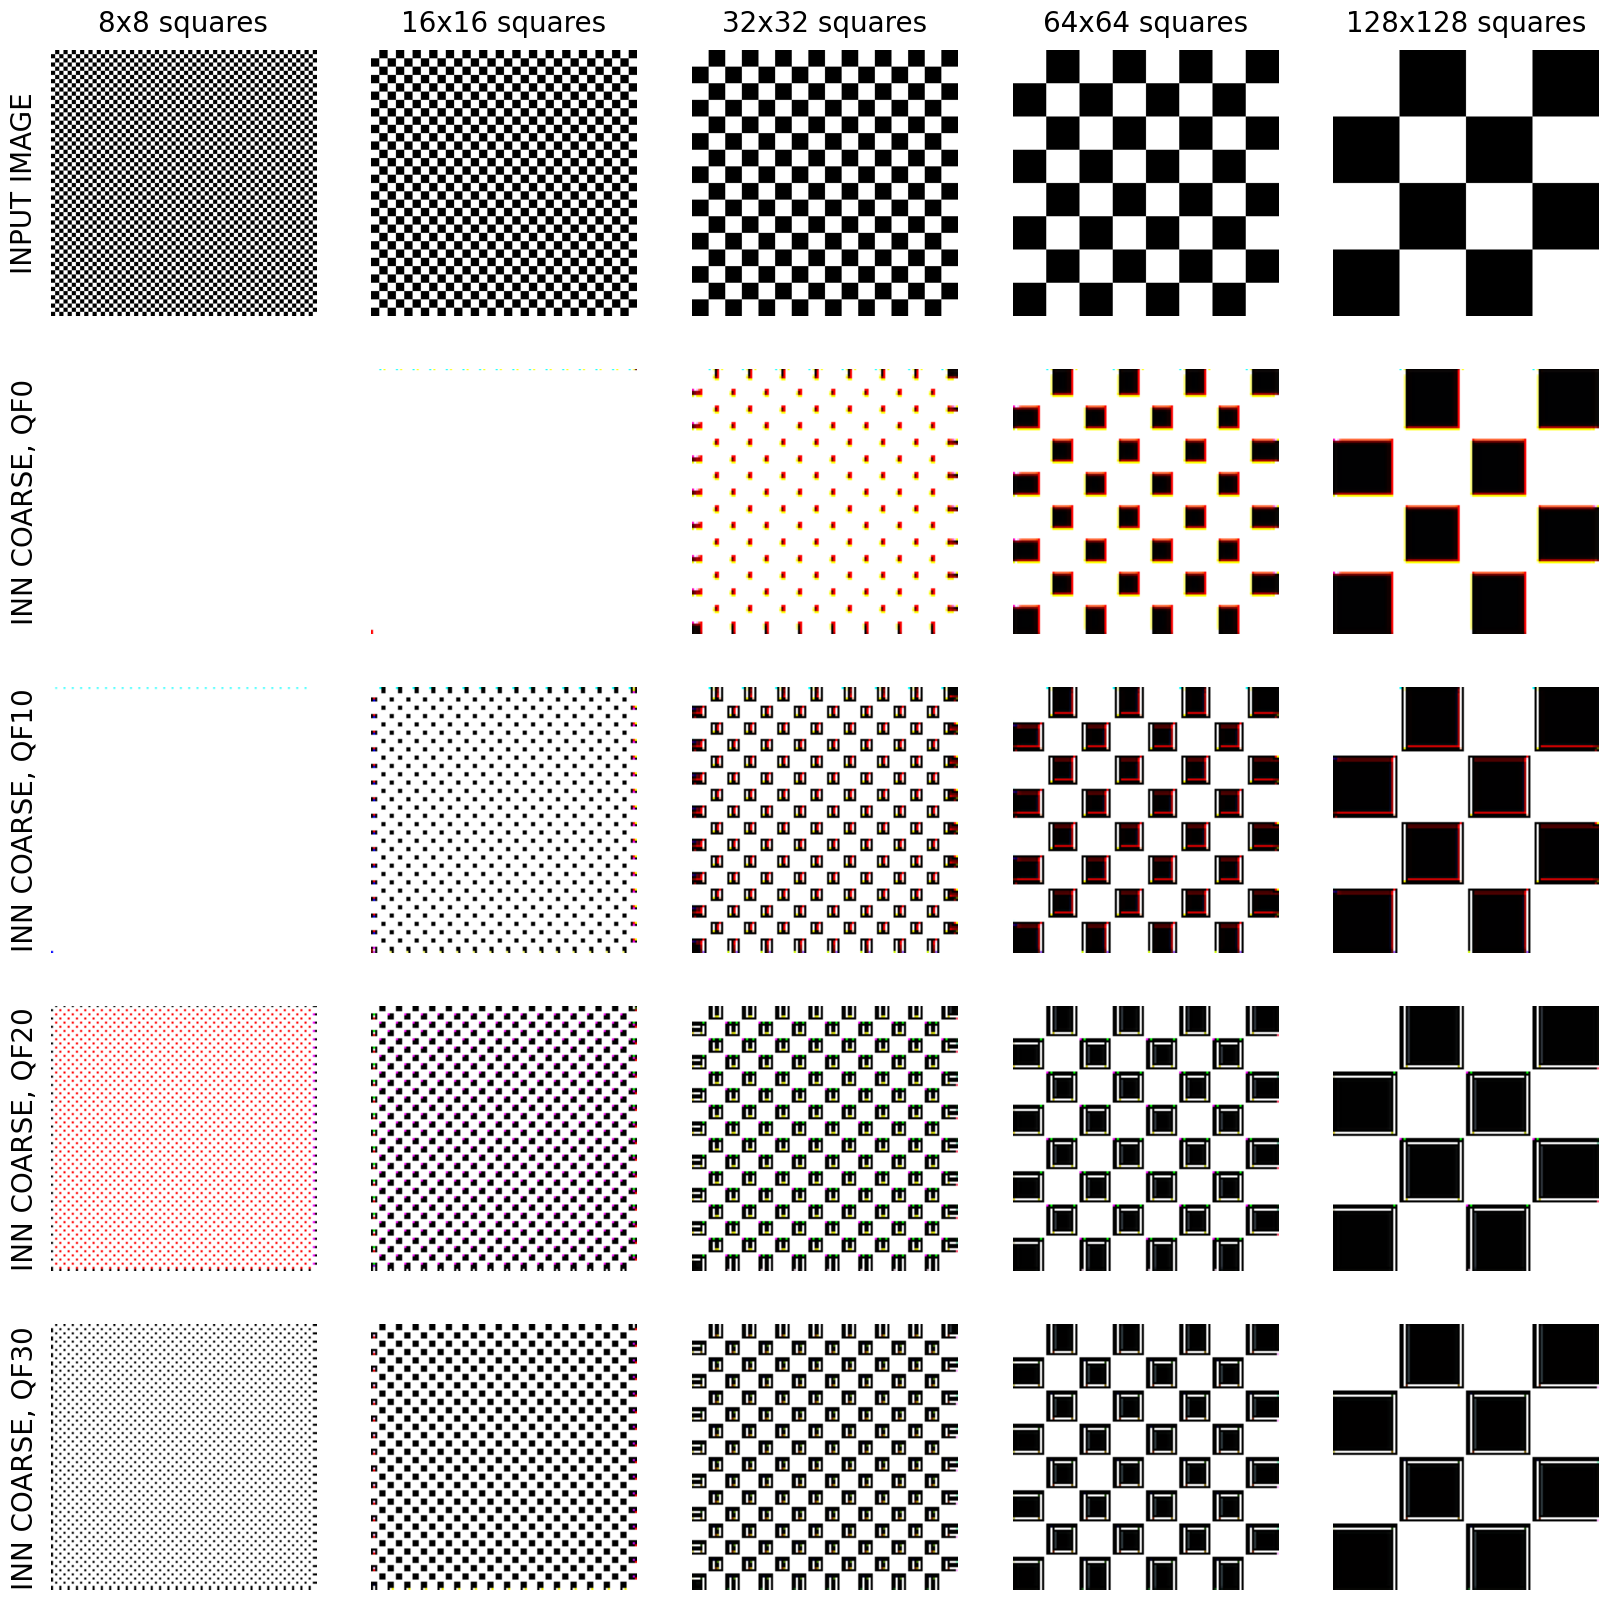

In [34]:
checkers = []
for i in range(3,8):
    check = generate_stripe_image(512, 512, stripe_width=(2**i), orientation='checkerboard')
    check = check[:,:,None]
    check = check.repeat(3,2)
    check = img2tensor(check).to(device)
    checkers.append(check)

qf = range(0, 50, 10)
checkers_coarse = []

for f in qf:
    checkers_coarse.append([])
    
    # Model
    INN_dir = f'weights/INN/large/INN_JPEG_QF{f}.pth'
    load_model(netG,INN_dir,strict=True)
    initial_inn_state = copy.deepcopy(model_inn.state_dict())
    model_inn.eval()
    freeze_model(model_inn)
    
    for i,check in enumerate(checkers):
        c, _ = model_inn.dae_f(x=check[None,:,:,:], cond=dummy_emb, layer=2)
        c = c.detach().cpu()
        c = tensor2img(c, rgb2bgr=False)[0]
        checkers_coarse[-1].append(c)

checkers_coarse.insert(0,[])
for check in checkers:
    check = check.detach().cpu()
    c = tensor2img(check, rgb2bgr=False)[0]
    checkers_coarse[0].append(c)

labels = [f'INN COARSE, QF{f}' for f in qf]
sizes = [f'{2**i}x{2**i} squares' for i in range(3,8)]
labels.insert(0, 'INPUT IMAGE')

fig, axs = plt.subplots(5,5, figsize=(20, 20))
for i in range(5):
    axs[i,0].text(-0.1, 0.5, labels[i], va='center', ha='center',
        rotation='vertical', fontsize=20, transform=axs[i,0].transAxes)
    axs[0,i].text(0.5,1.1, sizes[i], va='center', ha='center',
        rotation='horizontal', fontsize=20, transform=axs[0,i].transAxes)
    for j in range(5):
        axs[i,j].imshow(checkers_coarse[i][j])
        axs[i,j].axis('off')
        # axs[0,j].set_title(labels[j])

fig.show()

In [37]:
fig.savefig('figures/filtering_effect.png')

Models seem to learn to smoothen the image as the jpeg qf decreases. However, this also eliminates the possibility of 8x8 square artefacts being introduced in the coarse transform output. We are learning a wavelet transform that cannot introduce any components that were not present before.